### Imports 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False # makes autocomplete in jupyter faster

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

C:\Users\umwan\Anaconda3\envs\fastai-cpu\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Kaggle Data inload

I downloaded the data first and saved them onto my computer

In [3]:
PATH = "C:\\Users\\umwan\\Konstantin\\Programmieren\\MNIST Data\\"

In [4]:
test = pd.read_csv(f"{PATH}test.csv").to_numpy()

In [5]:
train = pd.read_csv(f"{PATH}train.csv")

In [6]:
subm = pd.read_csv(f"{PATH}sample_submission.csv")

In [7]:
x = train.drop('label', axis=1)[:35000].to_numpy()
y = train['label'][:35000].to_numpy()
x_valid = train.drop('label', axis=1)[35000:].to_numpy()
y_valid = train['label'][35000:].to_numpy()

In [8]:
print(x.shape, x_valid.shape, y.shape, y_valid.shape, sep ='\n')

(35000, 784)
(7000, 784)
(35000,)
(7000,)


### Normalize

Normalizing all pixels of all pictures in training, test and validation set.

In [9]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(33.39134413265306,
 78.65128171448335,
 -3.019993066765319e-16,
 1.0000000000000038)

In [10]:
test = (test-mean)/std
test.mean(), test.std()

(-0.0005060188898261933, 0.9995933586050861)

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(0.0013401208567038949, 1.0020159404973104)

### Looking at the data

In [12]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title, fontsize=20)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [14]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(7000, 28, 28)

In [15]:
test_imgs = np.reshape(test, (-1,28,28)); test.shape

(28000, 784)

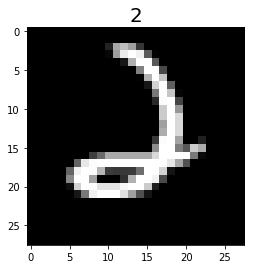

In [16]:
show(x_imgs[0], y_valid[0])

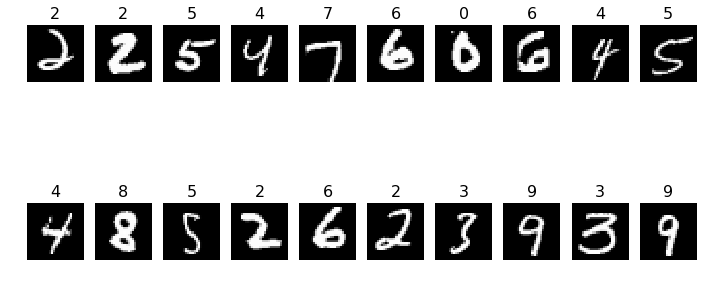

In [17]:
plots(x_imgs[0:20], titles=y_valid[0:20])

## Neural Net for Logistic Regression in PyTorch

In [18]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [19]:
u= 200
net = nn.Sequential(
    nn.Linear(28*28, u),
    nn.ReLU(),
    nn.Linear(u, u),
    nn.ReLU(),
    nn.Linear(u, u),
    nn.ReLU(),
    nn.Linear(u, 10),
    nn.LogSoftmax()
)#.cuda()

In [20]:
md = ImageClassifierData.from_arrays(PATH, (x,y), (x_valid, y_valid), test = test)

In [21]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.SGD(net.parameters(), 1e-2, momentum=0.9, weight_decay=1e-3)

### Fitting the model

In [22]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.206313   0.229348   0.925857  
    1      0.140446   0.122023   0.963                        
    2      0.096415   0.110355   0.966429                      
    3      0.077491   0.094182   0.972143                      
    4      0.066027   0.092965   0.971                         



[array([0.09297]), 0.971]

In [23]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                      
    0      0.050502   0.091109   0.973571  
    1      0.048387   0.095113   0.970429                      
    2      0.033229   0.079543   0.975429                      
    3      0.030496   0.092739   0.971                         
    4      0.026091   0.087012   0.972                         



[array([0.08701]), 0.972]

In [24]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                      
    0      0.017716   0.078174   0.974571  
    1      0.017353   0.07841    0.977286                      
    2      0.015752   0.075808   0.977                         
    3      0.014792   0.0794     0.975857                       
    4      0.01967    0.088764   0.973                          



[array([0.08876]), 0.973]

### Predictions of the validation set for checking

In [25]:
preds = predict(net, md.val_dl)

In [26]:
preds[0]

array([-10.01544, -17.67372,  -0.00005, -12.2775 , -17.64152, -17.5979 , -12.94259, -13.79672, -14.72322,
       -18.87752], dtype=float32)

The prediction for the first picture. For each number from 0 to 9 we get one probability. For the first picture the third value is the highest number (closest to zero), which is the number 2.

In [27]:
preds.argmax(1)[0]

2

In [28]:
preds = preds.argmax(1)

In [29]:
np.mean(preds == y_valid)

0.973

Pictures and their predictions

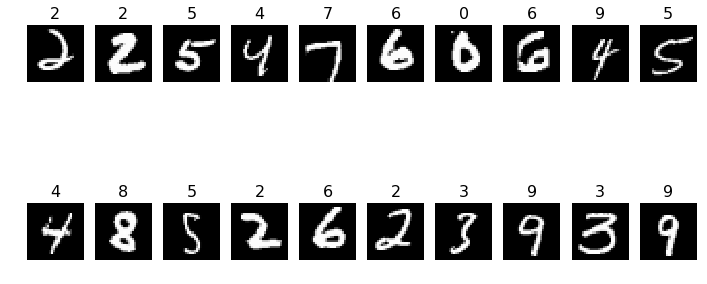

In [30]:
plots(x_imgs[:20], titles=preds[:20])

### Plotting my Outcomes

Bilding a confusion matrix:

In [31]:
cm = pd.DataFrame(np.zeros((10, 10)))

In [32]:
for i in range(len(preds)):
    cm.at[preds[i],y_valid[i]] +=1
#rows are the predictions, columns the valid numbers

In [33]:
cm

,0,1,2,3,4,5,6,7,8,9
0,708.0,0.0,4.0,2.0,1.0,3.0,3.0,1.0,0.0,4.0
1,0.0,770.0,0.0,2.0,2.0,0.0,2.0,1.0,2.0,0.0
2,0.0,1.0,650.0,7.0,0.0,1.0,0.0,5.0,1.0,1.0
3,0.0,0.0,5.0,694.0,0.0,2.0,0.0,0.0,2.0,0.0
4,0.0,0.0,0.0,0.0,673.0,0.0,2.0,0.0,0.0,8.0
5,0.0,0.0,1.0,8.0,0.0,575.0,1.0,1.0,3.0,3.0
6,6.0,2.0,1.0,0.0,4.0,5.0,703.0,0.0,1.0,0.0
7,0.0,2.0,2.0,3.0,0.0,0.0,0.0,703.0,0.0,4.0
8,1.0,5.0,7.0,8.0,6.0,6.0,0.0,3.0,678.0,4.0
9,1.0,1.0,1.0,5.0,19.0,8.0,0.0,5.0,0.0,657.0


In [34]:
lst = [[np.mean(preds[preds == i] == y_valid[preds==i])] for i in range(10)]

In [35]:
df = pd.DataFrame(lst, columns = ['Percentage correct by predictions']);df

,Percentage correct by predictions
0,0.975207
1,0.988447
2,0.975976
3,0.987198
4,0.985359
5,0.971284
6,0.973684
7,0.984594
8,0.944290
9,0.942611


In [36]:
lst = [[np.mean(y_valid[y_valid == i] == preds[y_valid==i])] for i in range(10)]

In [37]:
df = pd.DataFrame(lst, columns = ['Percentage correct by valid numbers']);df

,Percentage correct by valid numbers
0,0.988827
1,0.985915
2,0.968703
3,0.951989
4,0.954610
5,0.958333
6,0.988748
7,0.977747
8,0.986900
9,0.964758


### Looking at false rated pictures

In [46]:
ddf = pd.DataFrame(preds, columns = ['preds'])
ddf['y_valid'] = y_valid

In [47]:
false_pics = ddf[ddf['preds']!=ddf['y_valid']].index.values.tolist() 

In [48]:
# This is the same code, but much slower, becuase it uses a for-loop:
# false_pics = []
# for i in range(len(ddf)):
#     if ddf.iloc[i][0] != ddf.iloc[i][1]: false_pics.append(i)

An overview of the false rated pictures. Title = (prediction, valid number)

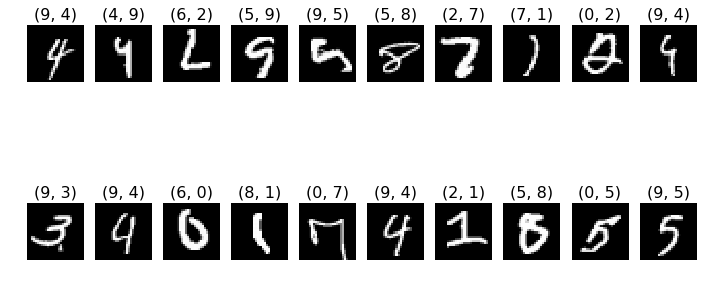

In [49]:
plots(x_imgs[false_pics[:20]], titles= [(i,j) for i, j in zip(preds[false_pics[:20]],y_valid[false_pics[:20]])])

Seeing through the false rated pictures, selecting the 'impossible' ones

In [50]:
i = iter(false_pics)

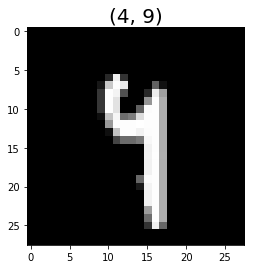

In [53]:
a = next(i)
show(x_imgs[a], (preds[a],y_valid[a]))

In [54]:
#impossible = []
#impossible.append(a)

impossible = [63, 159, 1018, 1569, 1571, 1894, 1916, 1984, 2013, 2290, 2529, 2544, 2719, 3191, 
4147, 4195, 4241, 4331, 4990, 5096, 6285, 6691, 6884, 6943]

In [57]:
print(impossible)

[63, 159, 1018, 1569, 1571, 1894, 1916, 1984, 2013, 2290, 2529, 2544, 2719, 3191, 4147, 4195, 4241, 4331, 4990, 5096, 6285, 6691, 6884, 6943]


Here are the hardest ones, or even wrong/impossible ones:

In [58]:
#r_impossible = []
#r_impossible.append(a)
r_impossible = [1018, 1916, 2290, 4195, 4990, 6691]

In [59]:
i = iter(r_impossible)

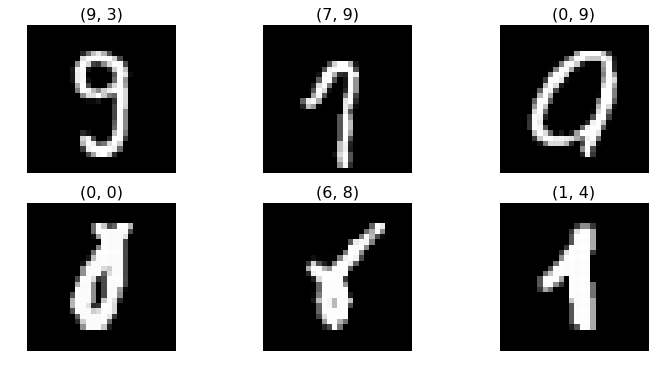

In [60]:
plots(x_imgs[r_impossible[:8]], titles= [(i,j) for i, j in zip(preds[r_impossible[:8]],y_valid[r_impossible[:8]])])

### Predictions of the test set for Kaggle

In [61]:
preds = predict(net, md.test_dl)

In [62]:
preds = preds.argmax(1)

Setting my predictions into the dataframe provided by kaggle:

In [63]:
subm['Label'] = preds

In [64]:
subm

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [65]:
subm.to_csv(r'C:\Users\umwan\Konstantin\Programmieren\MNIST Submission Kaggle\submission.csv', index = False)

### Kaggle Score

Score of this submission on Kaggle: 0.97628